In [91]:
%load_ext autoreload
%autoreload 2

import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
model_name = 'gpt2'

# prompt management

In [215]:
import json

def load_json_dataset(json_path):
    with open(json_path) as file:
        dataset = json.load(file)
    return dataset

dataset = load_json_dataset('../data/antonym.json')
dataset = list(map(lambda x: tuple(x.values()), dataset))
print(f'dataset len: {len(dataset)}')
dataset[:10]

dataset len: 2398


[('flawed', 'perfect'),
 ('orthodox', 'unorthodox'),
 ('true', 'false'),
 ('daily', 'nightly'),
 ('distribution', 'concentration'),
 ('valid', 'invalid'),
 ('expand', 'contract'),
 ('practical', 'impractical'),
 ('privilege', 'disadvantage'),
 ('mammoth', 'tiny')]

# models

In [147]:
import sys
sys.path.append('..')
torch.set_grad_enabled(False)

from src.utils.model_utils import load_gpt_model_and_tokenizer, set_seed, get_submodule
from src.extraction import split_activation, extract_activations, get_mean_activations
from src.utils.prompt_helper import build_prompt_txt, tokenize_from_template, tokenize_ICL
set_seed(32)

In [95]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model, config = load_gpt_model_and_tokenizer(model_name)
print(model)
print(config)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2AttentionAltered(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (query): WrapperModule()
          (key): WrapperModule()
          (value): WrapperModule()
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)
{'

Calculate the average of the activation on the dataset to grasp any pattern that is task-dependant and not token-dependant 

Activations have the following shape (num_layers, num_heads, seq_len, d_head), being each OV circuit output.

Still to answer:
- How this is connected to the residual stream?

Trying to use [nnsight](https://github.com/JadenFiotto-Kaufman/nnsight) and explore to know how it works

In [90]:
# select number of ICL examples
ICL_examples = 2

tok_ret, ids_ret = tokenize_ICL(tokenizer, ICL_examples = ICL_examples, dataset = dataset)
print(tok_ret[0])
print(ids_ret[0])

tensor([50256,    48,    25,    49,   462,   198,    32,    25, 45001,   628,
           48,    25, 18454,  6058,   198,    32,    25, 45355,   628,    48,
           25,  5840, 22506,   198,    32,    25])
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25]


___


In [152]:
mean_activation, outputs = get_mean_activations(
    tokenized_prompts=tok_ret,
    important_ids=ids_ret,
    model=model,
    config=config,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [217]:
mean_activation.shape
# mean_activation[0].mean(axis=0).mean(axis=1).shape

torch.Size([12, 12, 23, 64])

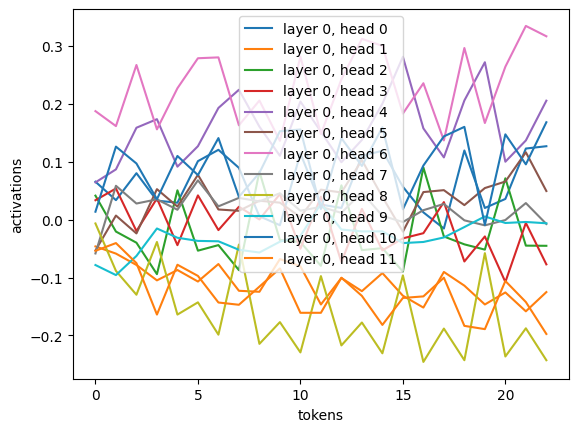

In [180]:

for i, layer in enumerate(mean_activation.detach().cpu()):
    for j, head in enumerate(layer):
        plt.plot(head.mean(axis = 1), label = f'layer {i}, head {j}')      # plotting last token activation
    break

plt.xlabel('tokens')
plt.ylabel('activations')
plt.legend()